<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/MNIST_with_TensorGraph_from_DeepChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DeepChem uses the *TensorGraph* class to construct nonstandard deep learning architectures.

We'll construct a convolutional architecture shown below:

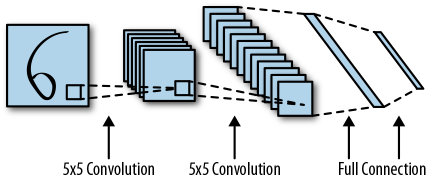

In [2]:
# SETUP DEEPCHEM
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem
deepchem.__version__

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  20236      0 --:--:-- --:--:-- --:--:-- 20236


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 573kB 8.5MB/s 


'2.6.0.dev'

## Loading dataset

In [3]:
import deepchem as dc
import deepchem.models.layers as layers
import numpy as np
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Softmax

In [4]:
mnist = tf.keras.datasets.mnist
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
# cast dtype for images
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')

In [6]:
# Tranforms labels like one-hot vectors
num_classes = 10
labels_train = to_categorical(labels_train, num_classes=num_classes)
labels_test = to_categorical(labels_test, num_classes=num_classes)

In [7]:
train_dataset = dc.data.NumpyDataset(images_train, labels_train)
test_dataset = dc.data.NumpyDataset(images_test, labels_test)
print(train_dataset)
print(test_dataset)

<NumpyDataset X.shape: (60000, 28, 28), y.shape: (60000, 10), w.shape: (60000, 1), task_names: [0 1 2 3 4 5 6 7 8 9]>
<NumpyDataset X.shape: (10000, 28, 28), y.shape: (10000, 10), w.shape: (10000, 1), task_names: [0 1 2 3 4 5 6 7 8 9]>


In [8]:
print(train_dataset.X.shape[1],"x", train_dataset.X.shape[2], "=", train_dataset.X.shape[1] * train_dataset.X.shape[2])
num_features = train_dataset.X.shape[1] * train_dataset.X.shape[2]
num_tasks = 10

28 x 28 = 784


## Defining architecture of the Convolutional Neural Network

In [9]:
# https://notebook.community/deepchem/deepchem/examples/tutorials/02_Learning_MNIST_Digit_Classifiers
keras_model = tf.keras.Sequential(layers=[
  Reshape((28, 28, 1)),
  Conv2D(filters=32, kernel_size=5, activation=tf.nn.relu),
  Conv2D(filters=64, kernel_size=5, activation=tf.nn.relu),
  Flatten(),
  Dense(1024, activation=tf.nn.relu),
  Dense(10),
  Softmax()
])

model = dc.models.KerasModel(model=keras_model, loss=dc.models.losses.CategoricalCrossEntropy())

## Training


In [10]:
model.fit(dataset=train_dataset, nb_epoch=10)

0.016151312589645386

## Measuring the performance

In [11]:
metric = dc.metrics.Metric(dc.metrics.accuracy_score)
# Accuracy over train and test datasets
train_scores = model.evaluate(train_dataset, [metric])
print("TRAIN SCORES", train_scores)
test_scores = model.evaluate(test_dataset, [metric])
print("TEST SCORES", test_scores)

TRAIN SCORES {'accuracy_score': 0.9991583333333335}
TEST SCORES {'accuracy_score': 0.9957800000000001}


## TESTING

In [49]:
random_index = np.random.randint(0, len(images_test))
print(tf.argmax(labels_test[random_index], axis=0))
print(labels_test[random_index])

prediction = model.predict_on_batch([test_dataset.X[random_index]])

prediction = np.squeeze(prediction)

categorical_prediction = tf.nn.softmax(prediction).numpy()
print(categorical_prediction)

categorical_prediction = np.squeeze(categorical_prediction)

index = -1
max_output = 0.0
for i in range(len(categorical_prediction)):
  if categorical_prediction[i] > max_output:
    max_output = categorical_prediction[i]
    index = i


print("PREDICTION {} with prob:{} ".format(index, categorical_prediction[index]))



tf.Tensor(8, shape=(), dtype=int64)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.08533674
 0.08533674 0.08533674 0.2319693  0.08533674]
PREDICTION 8 with prob:0.23196929693222046 
